In [1]:
from processing.processor import *
from analysis.analysis import *
import numpy as np
from scipy.spatial.distance import cdist, pdist
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data

In [2]:
p = CifProcessor()
p.read_pkl_metainfo()
p.read_pkl(mode='rg', folder='data/processed/')

  3%|█▋                                                                | 14/557 [00:00<00:03, 136.30it/s]

Reading files with generic numbers on receptors and gproteins.


100%|█████████████████████████████████████████████████████████████████| 557/557 [00:04<00:00, 113.83it/s]


In [3]:
ATOM_LIST=['CA']

In [4]:
f_act = p.make_filter(State='Active', Cl='Rhodopsin', gprotein=True)
# f_act = f_act[f_act['Method']=='cryo-EM']

In [5]:
len(f_act)

83

In [6]:
f_act[f_act['Family'].str.contains('q')]

,uniprot(gene),receptor family,Cl.,Species,Method,PDB,Resolution,Preferred Chain,State,Degree active %,Family,Subtype,Function
16,ACM1,Acetylcholine(muscarinic),A(Rhodopsin),Human,cryo-EM,6OIJ,3.3,R,Active,100,Gq/11,α11,Agonist
32,5HT2A,5-Hydroxytryptamine,A(Rhodopsin),Human,cryo-EM,6WHA,3.4,A,Active,100,Gq/11,αq,Agonist
71,HRH1,Histamine,A(Rhodopsin),Human,cryo-EM,7DFL,3.3,R,Active,100,Gq/11,αq,Agonist
76,CCKAR,Cholecystokinin,A(Rhodopsin),Human,cryo-EM,7MBY,2.4,R,Active,100,Gq/11,αq,Agonist


In [7]:
p.apply_filter(f_act)

In [8]:
len(p.dfl_list)

83

In [9]:
p.dfl_list.index('7MBY')

82

In [10]:
df = p.dfl[66]

In [11]:
df[df['gprot_pos'] != '']

,PDB,group_PDB,auth_asym_id,label_asym_id,label_seq_id,auth_seq_id,label_comp_id,id,label_atom_id,type_symbol,...,identifier,label_comp_sid,label_2_uni,gen_pos,gen_pos1,gen_pos2,uniprot_comp_sid,gprot_pos,uniprot_comp_id,fam_comp_id
7016,7JJO,ATOM,A,C,19,15,GLU,7017,CA,C,...,ADRB1_MELGA,E,14,,0.0,0.0,,G.HN.32,E,E
7023,7JJO,ATOM,A,C,20,16,GLU,7024,CA,C,...,ADRB1_MELGA,E,15,,0.0,0.0,,G.HN.33,E,E
7030,7JJO,ATOM,A,C,21,17,LYS,7031,CA,C,...,ADRB1_MELGA,K,16,,0.0,0.0,,G.HN.34,K,K
7037,7JJO,ATOM,A,C,22,18,GLY,7038,CA,C,...,ADRB1_MELGA,G,17,,0.0,0.0,,G.HN.35,A,A
7044,7JJO,ATOM,A,C,23,19,GLN,7045,CA,C,...,ADRB1_MELGA,Q,18,,0.0,0.0,,G.HN.36,Q,Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,7JJO,ATOM,A,C,380,376,GLN,10235,CA,C,...,ADRB1_MELGA,Q,375,,0.0,0.0,,G.H5.08,F,F
10251,7JJO,ATOM,A,C,381,377,TYR,10252,CA,C,...,ADRB1_MELGA,Y,376,,0.0,0.0,,G.H5.09,N,N
10272,7JJO,ATOM,A,C,382,378,GLU,10273,CA,C,...,ADRB1_MELGA,E,377,,0.0,0.0,,G.H5.10,D,D
10287,7JJO,ATOM,A,C,383,379,LEU,10288,CA,C,...,ADRB1_MELGA,L,378,,0.0,0.0,,G.H5.11,C,C


In [12]:
eg = 47

In [13]:
def run_angle_analysis(p, col_name='angle', start=3.40, end=3.53, gprot_region='H5', gstart=3, gend=15):
    p.table[col_name] = 0.000
    for pdb in p.dfl_list: #p.dfl_list
        i = p.dfl_list.index(pdb)
        if pdb != p.dfl[i]['PDB'].iloc[0]:
            print("dfl list and df in dfl at corr index do not match!")
        if 'gen_pos' and 'gprot_pos' in list(p.dfl[i].columns):
            pass
        else:
            continue

        df_r = section_filter(p.dfl[i].copy(), chain='r', start=start, end=end)
        df_g = section_filter(p.dfl[i].copy(), chain='g', gprot_region=gprot_region, start=gstart, end=gend)
        if len(df_r) > 0:
            if len(df_r[df_r['gen_pos'].str.contains('\?')])>30:
                df_r = df_r[~df_r['gen_pos'].str.contains('\?')]
                pass
        xyz_r, mean_r = get_coords(df_r, False)
        xyz_g, mean_g = get_coords(df_g, False)

        if (xyz_r.shape[0]>6) & (xyz_g.shape[0]>6):
            v_r = get_helix(xyz_r-np.asarray(mean_r))
            v_g = get_helix(xyz_g-np.asarray(mean_g))
            vector_r = v_r * np.mgrid[-10:10:2j][:, np.newaxis]
            vector_g = v_g * np.mgrid[-10:10:2j][:, np.newaxis]
            angle_ = angle(v_r, v_g)
            if angle_ < 0:
                angle_ = -angle_
            if angle_ > 180:
                angle_ = angle_ - 180
            if angle_ > 90:
                angle_ = 180 - angle_
            p.table.loc[p.table['PDB']==pdb, col_name] = angle_

In [14]:
run_angle_analysis(p, '3.5vsH5.3_15', start=3.40, end=3.53, gstart=3, gend=15)
run_angle_analysis(p, '3.5vsH5.16_26', start=3.40, end=3.53, gstart=16, gend=26)
run_angle_analysis(p, '8.5vsH5.3_15', start=8.53, end=8.63, gstart=3, gend=15)
run_angle_analysis(p, '8.5vsH5.16_26', start=8.53, end=8.63, gstart=16, gend=26)
run_angle_analysis(p, '3.5vsHN.30_53', start=3.40, end=3.53, gprot_region='HN', gstart=30, gend=53)
run_angle_analysis(p, '8.5vsHN.30_53', start=8.53, end=8.63, gprot_region='HN', gstart=30, gend=53)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

def make_plot(data, col='3.5vsH5.3_15', save=True):

    a4_dims = (11.7, 8.27)
    fontsize = 20

    fig, axes = plt.subplots(figsize=a4_dims)
    sns.violinplot('Family', col, data=data[data[col]>0], ax = axes)

    axes.yaxis.grid(False)
    axes.set_xlabel('G protein family')
    axes.set_ylabel('Angle (°)')
    matplotlib.rcParams.update({'font.size': fontsize})

    if save:
        plt.rcParams['savefig.dpi'] = 300
        name = 'plots/mt/'+col.replace('.', '_')+'.png'
        plt.savefig(name)
    else:
        plt.show()

C:\Users\Sideadmin\.conda\envs\mt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


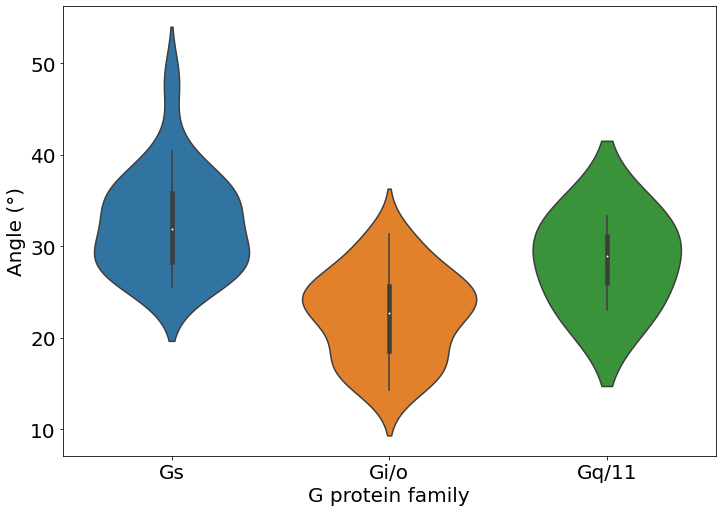

In [36]:
make_plot(p.table, col='3.5vsH5.3_15')

C:\Users\Sideadmin\.conda\envs\mt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


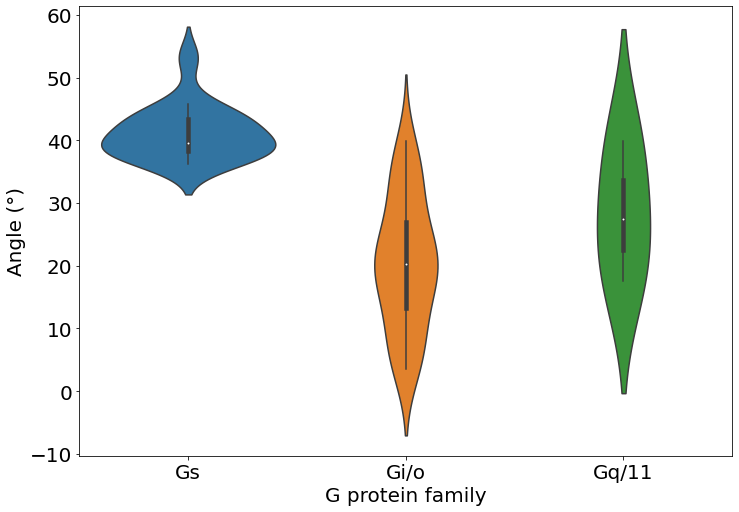

In [37]:
make_plot(p.table, col='3.5vsH5.16_26')

C:\Users\Sideadmin\.conda\envs\mt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


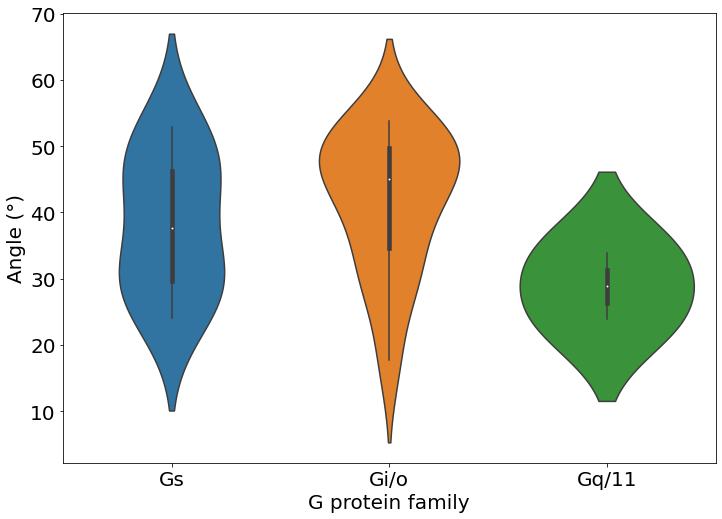

In [38]:
make_plot(p.table, col='8.5vsH5.3_15')

C:\Users\Sideadmin\.conda\envs\mt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


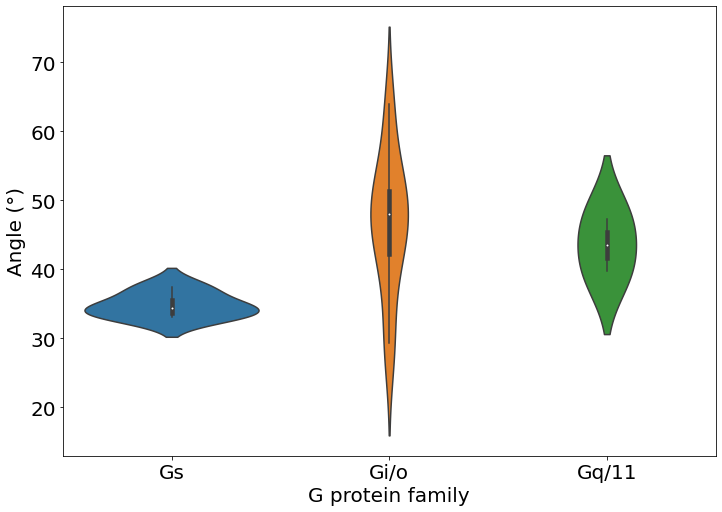

In [39]:
make_plot(p.table, col='8.5vsH5.16_26')

C:\Users\Sideadmin\.conda\envs\mt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


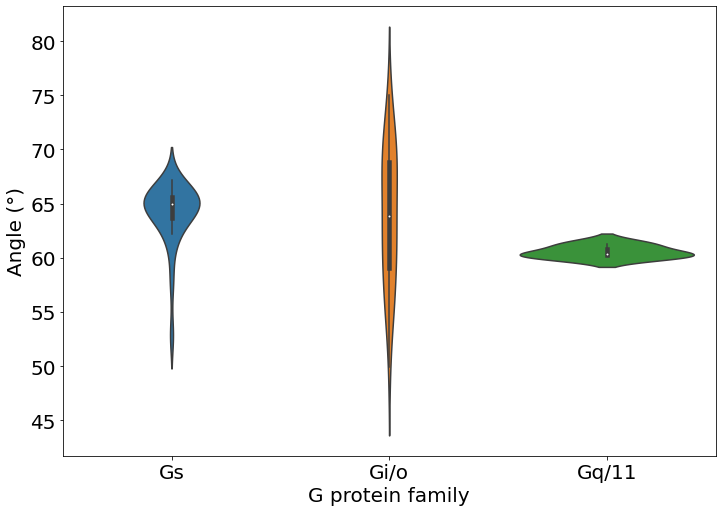

In [40]:
make_plot(p.table, col='3.5vsHN.30_53')

C:\Users\Sideadmin\.conda\envs\mt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


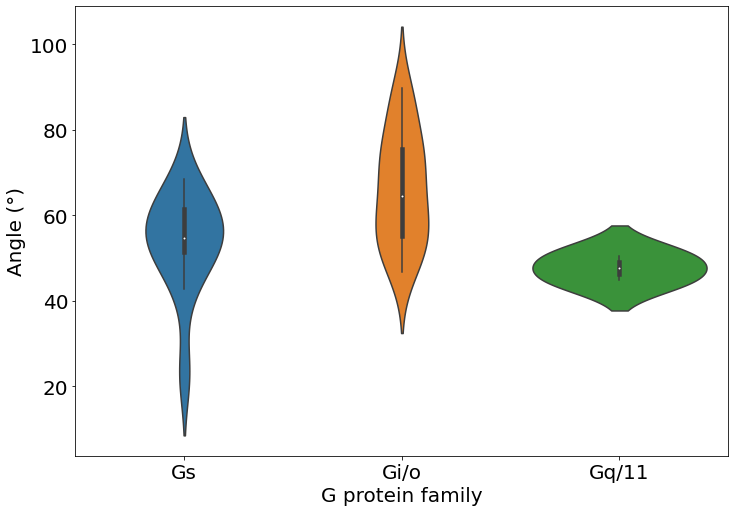

In [41]:
make_plot(p.table, col='8.5vsHN.30_53')

In [42]:
small[(p.table['angle']>0)&(small['Family']=='Gs')].sort_values('uniprot(gene)').reset_index(drop=True)

NameError: name 'small' is not defined

In [ ]:
small = p.table[['PDB', 'uniprot(gene)', 'Family', 'angle']].copy()
small[(p.table['angle']>0)&(small['Family']=='Gi/o')].sort_values('uniprot(gene)').reset_index(drop=True)#.to_csv('gio_angle_tm3_h5.csv')

In [ ]:
small[(p.table['angle']>0)&(small['Family']=='Gq/11')].sort_values('uniprot(gene)').reset_index(drop=True)

In [ ]:
df = p.dfl[p.dfl_list.index('7CFM')]

In [ ]:
df[df['gprot_pos'].str.contains('HN')]

In [ ]:
df[(df['gen_pos1']>=8.5)&(df['gen_pos1']<=9)&(df['label_atom_id']=='CA')]

In [ ]:
small[small['Family']=='Gs'].reset_index(drop=True).sort_values('uniprot(gene)') #.to_csv('gs_angle_tm3_h5.csv')

In [ ]:
small[small['Family']=='Gq/11'].reset_index(drop=True).sort_values('uniprot(gene)')#.to_csv('gq_angle_tm3_h5.csv')

In [ ]:
pdb = '6N4B'
i = p.dfl_list.index(pdb)
if pdb != p.dfl[i]['PDB'].iloc[0]:
    print("dfl list and df in dfl at corr index do not match!")

df_rh8 = section_filter(p.dfl[i].copy(), chain='r', start=8.50, end=8.60)
df_rtm7 = section_filter(p.dfl[i].copy(), chain='r', start=7.40, end=7.53)
df_g = section_filter(p.dfl[i].copy(), chain='g', gprot_region='H5', start=1, end=27)
if len(df_r) > 0:
    if len(df_r[df_r['gen_pos'].str.contains('\?')])>3:
        df_r = df_r[~df_r['gen_pos'].str.contains('\?')]
        pass
xyz_r1, mean_r1 = get_coords(df_rh8, False)
xyz_r2, mean_r2 = get_coords(df_rtm7, False)

print(xyz_r1.shape)
print(xyz_r2.shape)
xyz_g, mean_g = get_coords(df_g, False)

if (xyz_r1.shape[0]>6) & (xyz_r2.shape[0]>6) & (xyz_g.shape[0]>6):
    v_r1 = get_helix(xyz_r1-np.asarray(mean_r1))
    v_r2 = get_helix(xyz_r2-np.asarray(mean_r2))
    v_g = get_helix(xyz_g-np.asarray(mean_g))
    vector_r1 = v_r1 * np.mgrid[-10:10:2j][:, np.newaxis]
    vector_r2 = v_r2 * np.mgrid[-10:10:2j][:, np.newaxis]
    vector_g = v_g * np.mgrid[-10:10:2j][:, np.newaxis]

    angle_ = angle(v_r1, v_g)
    if angle_ < 90:
        angle_ = 180 - angle_
print(angle_)

In [ ]:
vector_r1

# Plotting helices

In [ ]:
plot_helices([[xyz_r1, vector_r1, mean_r1, 'Receptor'],
              [xyz_r2, vector_r2, mean_r2, 'Receptor'], 
              [xyz_g, vector_g, mean_g, 'Gprotein']])

In [ ]:
plot_helices([[xyz_r, vector_r, mean_r, 'Receptor'], [xyz_g, vector_g, mean_g, 'Gprotein']]) # 	7E2X

In [ ]:
plot_helices([[xyz_r, vector_r, mean_r, 'Receptor'], [xyz_g, vector_g, mean_g, 'Gprotein']]) # 	7E2Y

In [ ]:
# full interaction table

In [ ]:
pdb = '6N4B'
i = p.dfl_list.index(pdb)
if pdb != p.dfl[i]['PDB'].iloc[0]:
    print("dfl list and df in dfl at corr index do not match!")

df_r = section_filter(p.dfl[i].copy(), chain='r', start=3.40, end=3.53)
df_g = section_filter(p.dfl[i].copy(), chain='g', gprot_region='H5', start=3, end=22)
if len(df_r) > 0:
    if len(df_r[df_r['gen_pos'].str.contains('\?')])>3:
        df_r = df_r[~df_r['gen_pos'].str.contains('\?')]
        pass
xyz_r, mean_r = get_coords(df_r, False)
xyz_g, mean_g = get_coords(df_g, False)

if (xyz_r.shape[0]>6) & (xyz_g.shape[0]>6):
    v_r = get_helix(xyz_r-np.asarray(mean_r))
    v_g = get_helix(xyz_g-np.asarray(mean_g))
    vector_r = v_r * np.mgrid[-10:10:2j][:, np.newaxis]
    vector_g = v_g * np.mgrid[-10:10:2j][:, np.newaxis]

    angle_ = angle(v_r, v_g)
    if angle_ < 90:
        angle_ = 180 - angle_

# Full Helices Table

In [ ]:
G_SECTION_DICT = {}
R_SECTION_DICT = {'TM1': (1.45, 1.55),
                  'TM2': (2.45, 2.55),
                  'TM3': (3.40, 3.53),
                  'TM4': (4.45, 4.55),
                  'TM5': (5.45, 5.55),
                  'TM6': (6.45, 6.55),
                  'TM7': (7.4, 7.53),
                  'H8':  (8.5, 8.6),}

In [ ]:
def count_g_positions(data):
    cols = [x for x in range(100)]
    gs_count_df = pd.DataFrame(columns=cols)
    g_section_list = list(G_SECTION_DICT.keys())
    for i in range(len(data)):
        df = data[i]
        if 'gprot_pos' in list(df.columns):
            new_g_section_list = list(set([x.split('.')[1] for x in df.gprot_pos.unique() if len(x.split('.'))==3]))
            g_section_list += new_g_section_list
            for gs in new_g_section_list:
                if gs not in list(gs_count_df.index):
                    gs_count_df.loc[gs,:] = 0
                posis = [int(x.split('.')[-1]) for x in df.gprot_pos.unique() if (gs in x) & (len(x.split('.'))==3)]
                for pos in posis:
                    gs_count_df.loc[gs, pos] += 1
    return gs_count_df.sort_index()

In [ ]:
def find_cont_sections_g(gs_count_df, min_count=40, min_length=8):
    def find_sections(nums, min_length):
        nums.sort()
        nums.append(1e9)
        ans=[]
        l=nums[0]
        for i in range(1,len(nums)):
            if nums[i] != nums[i-1] + 1:
                if (nums[i-1] - l) >= min_length:
                    ans.append((l, nums[i-1]))
                l=nums[i]
        return ans
    g_section_dict = {}
    for section in list(gs_count_df.index):
        sec = gs_count_df.loc[section, (gs_count_df > 0).any(axis=0)]
        sec = sec.to_dict()
        sec_keys = [x for x in list(sec.keys()) if sec[x] >= min_count]
        g_section_dict[section] = find_sections(sec_keys, min_length)
    return g_section_dict

In [ ]:
def make_cont_section_dict_g(cont_sec_g):
    cont_sec_g_dict = {}
    for key in list(cont_sec_g.keys()):
        sections = cont_sec_g[key]
        for s, sec in enumerate(sections):
            cont_sec_g_dict[key+'_'+str(s)] = sec
    return cont_sec_g_dict

In [ ]:
gs_count_df = count_g_positions(p.dfl)

In [ ]:
gs_count_df

In [ ]:
# list(set(list(g_section_list)))

In [ ]:
cont_sec_g = find_cont_sections_g(gs_count_df, min_count=30, min_length=6)

In [ ]:
G_SECTION_DICT = make_cont_section_dict_g(cont_sec_g)

In [ ]:
G_SECTION_DICT['H5_1'] = (13, 23)
G_SECTION_DICT['H4_0'] = (3, 15)

In [ ]:
G_SECTION_DICT

In [ ]:
def calculate_section_helices(data):
    g_section_list = list(G_SECTION_DICT.keys())
    r_section_list = list(R_SECTION_DICT.keys())
    columns = g_section_list + r_section_list
    section_diff_df = pd.DataFrame(columns=columns)
    for i in range(len(data)):
        pdb = data[i].iloc[0]['PDB']
        if 'gen_pos' and 'gprot_pos' in list(data[i].columns):
            for c in columns:
                if c in r_section_list:
                    df_r = section_filter(data[i].copy(), chain='r', start=R_SECTION_DICT[c][0], end=R_SECTION_DICT[c][1])
                    if len(df_r) > 0:
                        if len(df_r[df_r['gen_pos'].str.contains('\?')])>3:
                            df_r = df_r[~df_r['gen_pos'].str.contains('\?')]
                    xyz_r, mean_r = get_coords(df_r, False)
                    if (xyz_r.shape[0]>6):
                        v_r = get_helix(xyz_r-np.asarray(mean_r))
                        section_diff_df.loc[pdb, c] = v_r
                elif (c in g_section_list):
                    c_, c_idx = c.split('_')
                    if c_ in [x.split('.')[1] for x in list(data[i].gprot_pos.unique()) if len(x.split('.'))==3]:
                        df_g = section_filter(data[i].copy(), chain='g', gprot_region=c_, 
                                              start=G_SECTION_DICT[c][0], end=G_SECTION_DICT[c][1])
                        xyz_g, mean_g = get_coords(df_g, False)
                        if (xyz_g.shape[0]>6):
                            v_g = get_helix(xyz_g-np.asarray(mean_g))
                            section_diff_df.loc[pdb, c] = v_g
    return section_diff_df

In [ ]:
p.dfl[0]

In [ ]:
R_SECTION_DICT['TM6']

In [ ]:
section_helices = calculate_section_helices(p.dfl)

In [ ]:
section_helices.reset_index()['H4_0'].iloc[2]

In [ ]:
section_helices.loc['3SN6', 'H1_0']

In [ ]:
rois = list(section_helices.columns)

In [ ]:
def calc_angles_between_helices(section_helices, idx):
    cols = list(section_helices.columns)
    section_angles_df = pd.DataFrame(columns=cols)
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            if i != j:
                section_helix1 = section_helices[c1].iloc[idx]
                section_helix2 = section_helices[c2].iloc[idx]
                if not (isinstance(section_helix1, float) | isinstance(section_helix2, float)):
                    angle_ = angle(section_helix1, section_helix2)
                    if angle_ > 90:
                        angle_ = 180 - angle_
                    section_angles_df.loc[c1, c2] = angle_
                else:
                    section_angles_df.loc[c1, c2] = np.nan
            else:
                section_angles_df.loc[c1, c2] = 0.000000
    return section_angles_df.T

In [ ]:
calc_angles_between_helices(section_helices, 2)

In [ ]:
ang_helices = []
for i in range(len(section_helices)):
    ang_helices.append(calc_angles_between_helices(section_helices, i))

In [ ]:
std_df = pd.DataFrame(columns=rois)
mean_df = pd.DataFrame(columns=rois)
for r1, roi1 in enumerate(rois):
    for r2, roi2 in enumerate(rois):
        l_r1r2 = []
        for df in ang_helices:
            cell = df.loc[roi1, roi2]
            if cell > 0:
                l_r1r2.append(cell)
        if len(l_r1r2) > 0:
            mean_r1r2 = np.mean(l_r1r2)
            std_r1r2 = np.std(l_r1r2)
            std_df.loc[roi1, roi2] = std_r1r2
            mean_df.loc[roi1, roi2] = mean_r1r2

# Plotting STD for helix angles

In [ ]:
std_df

In [ ]:
std_df_interaction = std_df.loc[list(G_SECTION_DICT.keys()), list(R_SECTION_DICT)].copy()

In [ ]:
std_df_gprot = std_df.loc[list(G_SECTION_DICT.keys()), list(G_SECTION_DICT)].copy()

In [ ]:
std_df_receptor = std_df.loc[[x for x in list(R_SECTION_DICT.keys()) if x!='H8'],list(R_SECTION_DICT.keys())].copy()

In [ ]:
name = 'Standard deviation in helices directional angles'
rcParams['figure.figsize'] = 20, 15
low_section = 50
high_section = 180
dense_map = std_df_interaction[(std_df_interaction < low_section) | (std_df_interaction > high_section)]\
    .dropna(axis=0, how='all').dropna(axis=1, how='all')
ax = sns.heatmap(dense_map.astype(float), cmap='RdYlGn_r', linewidths=.1)
ax.set_title(name)
ax.plot()

In [ ]:
name = 'Standard deviation in helices directional angles'
rcParams['figure.figsize'] = 20, 15
low_section = 20
high_section = 60
dense_map = std_df_gprot[(std_df_gprot < low_section) | (std_df_gprot > high_section)]\
    .dropna(axis=0, how='all').dropna(axis=1, how='all')
ax = sns.heatmap(dense_map.astype(float), cmap='RdYlGn_r', linewidths=.1)
ax.set_title(name)
ax.plot()

In [ ]:
name = 'Standard deviation in helices directional angles'
rcParams['figure.figsize'] = 20, 15
low_section = 50
high_section = 100
dense_map = std_df_receptor[(std_df_receptor < low_section) | (std_df_receptor > high_section)]\
    .dropna(axis=0, how='all').dropna(axis=1, how='all')
ax = sns.heatmap(dense_map.astype(float), cmap='RdYlGn_r', linewidths=.1)
ax.set_title(name)
ax.plot()

In [ ]:
name = 'Standard deviation in helices directional angles'
rcParams['figure.figsize'] = 20, 15
low_section = 6
high_section = 180
dense_map = std_df[(std_df < low_section) | (std_df > high_section)]\
    .dropna(axis=0, how='all').dropna(axis=1, how='all')
ax = sns.heatmap(dense_map.astype(float), cmap='RdYlGn_r', linewidths=.1)
ax.set_title(name)
ax.plot()

In [ ]:
name = 'Mean in helices directional angles'
rcParams['figure.figsize'] = 20, 15
ax = sns.heatmap(mean_df.astype(float), cmap='RdYlGn_r', linewidths=.1)
ax.set_title(name)
ax.plot()

# H5, HN

In [ ]:
p.table['angle'] = 0.000
for pdb in p.dfl_list: #p.dfl_list
    i = p.dfl_list.index(pdb)
    if 'gprot_pos' in list(p.dfl[i]):
        if pdb != p.dfl[i]['PDB'].iloc[0]:
            print("dfl list and df in dfl at corr index do not match!")

        df_g1 = section_filter(p.dfl[i].copy(), chain='g', gprot_region='HN', start=30, end=53)
        df_g2 = section_filter(p.dfl[i].copy(), chain='g', gprot_region='H5', start=3, end=23)

        if len(df_r) > 0:
            if len(df_r[df_r['gen_pos'].str.contains('\?')])>3:
                df_r = df_r[~df_r['gen_pos'].str.contains('\?')]

        xyz_1, mean_1 = get_coords(df_g1, False)
        xyz_2, mean_2 = get_coords(df_g2, False)

        if (xyz_1.shape[0]>6) & (xyz_2.shape[0]>6):
            v_1 = get_helix(xyz_1-np.asarray(mean_1))  # UNDIRECTED
            v_2 = get_helix(xyz_2-np.asarray(mean_2))
            angle_ = angle(v_1, v_2)
            if angle_ > 90:
                angle_ = 180 - angle_
            print(pdb, angle_, p.table[p.table['PDB']==pdb]['Family'].iloc[0])
            p.table.loc[p.table['PDB']==pdb, 'angle'] = angle_

In [ ]:
small = p.table[['PDB', 'uniprot(gene)', 'Family', 'angle']].copy()
small[(p.table['angle']>0)&(small['Family']=='Gi/o')].sort_values('uniprot(gene)').reset_index(drop=True)\
    .to_csv('gio_angle_hn_h5.csv')

In [ ]:
small[(p.table['angle']>0)&(small['Family']=='Gs')].sort_values('uniprot(gene)').reset_index(drop=True)\
    .to_csv('gs_angle_hn_h5.csv')

In [ ]:
small[(p.table['angle']>0)&(small['Family']=='Gq/11')].sort_values('uniprot(gene)').reset_index(drop=True)\
    .to_csv('gs_angle_hn_h5.csv')

In [ ]:
p.table[p.table['angle']>0].groupby('Family').std()['angle']

# H5 - H5 

In [ ]:
p.table['angle'] = 0.000
for pdb in p.dfl_list: #p.dfl_list
    i = p.dfl_list.index(pdb)
    if 'gprot_pos' in list(p.dfl[i]):
        if pdb != p.dfl[i]['PDB'].iloc[0]:
            print("dfl list and df in dfl at corr index do not match!")

        df_g1 = section_filter(p.dfl[i].copy(), chain='g', gprot_region='H5', start=3, end=13)
        df_g2 = section_filter(p.dfl[i].copy(), chain='g', gprot_region='H5', start=13, end=24)
        if len(df_r) > 0:
            if len(df_r[df_r['gen_pos'].str.contains('\?')])>3:
                df_r = df_r[~df_r['gen_pos'].str.contains('\?')]
                pass
        xyz_1, mean_1 = get_coords(df_g1, False)
        xyz_2, mean_2 = get_coords(df_g2, False)

        if (xyz_1.shape[0]>6) & (xyz_2.shape[0]>6):
            v_1 = get_helix(xyz_1-np.asarray(mean_1))  # UNDIRECTED
            v_2 = get_helix(xyz_2-np.asarray(mean_2))
            angle_ = angle(v_1, v_2)
            if angle_ > 90:
                angle_ = 180 - angle_
            print(pdb, angle_, p.table[p.table['PDB']==pdb]['Family'].iloc[0])
            p.table.loc[p.table['PDB']==pdb, 'angle'] = angle_

In [ ]:
small = p.table[['PDB', 'uniprot(gene)', 'Family', 'angle']].copy()
small[(p.table['angle']>0)&(small['Family']=='Gi/o')].sort_values('uniprot(gene)').reset_index(drop=True)\
    .to_csv('gio_angle_h5_h5.csv')

In [ ]:
small[(p.table['angle']>0)&(small['Family']=='Gs')].sort_values('uniprot(gene)').reset_index(drop=True)\
    .to_csv('gs_angle_h5_h5.csv')

In [ ]:
small[(p.table['angle']>0)&(small['Family']=='Gq/11')].sort_values('uniprot(gene)').reset_index(drop=True)\
    .to_csv('gq11_angle_h5_h5.csv')

In [ ]:
p.table[p.table['angle']>0].groupby('Family').std()['angle']

# TM3 H5

In [ ]:
p.table['angle'] = 0.000
for pdb in p.dfl_list: #p.dfl_list
    if 'gprot_pos' in list(p.dfl[i].columns):
        i = p.dfl_list.index(pdb)
        if pdb != p.dfl[i]['PDB'].iloc[0]:
            print("dfl list and df in dfl at corr index do not match!")

        df_r = section_filter(p.dfl[i].copy(), chain='r', start=3.40, end=3.53)
        df_g = section_filter(p.dfl[i].copy(), chain='g', gprot_region='H5', start=3, end=22)
        if len(df_r) > 0:
            if len(df_r[df_r['gen_pos'].str.contains('\?')])>3:
                df_r = df_r[~df_r['gen_pos'].str.contains('\?')]
                pass
        xyz_r, mean_r = get_coords(df_r, False)
        xyz_g, mean_g = get_coords(df_g, False)

        if (xyz_r.shape[0]>6) & (xyz_g.shape[0]>6):
            v_r = get_helix(xyz_r-np.asarray(mean_r))
            v_g = get_helix(xyz_g-np.asarray(mean_g))
            vector_r = v_r * np.mgrid[-10:10:2j][:, np.newaxis]
            vector_g = v_g * np.mgrid[-10:10:2j][:, np.newaxis]

            angle_ = angle(v_r, v_g)
            if angle_ > 90:
                angle_ = 180 - angle_
            print(pdb, angle_, p.table[p.table['PDB']==pdb]['Family'].iloc[0])
            p.table.loc[p.table['PDB']==pdb, 'angle'] = angle_

In [ ]:
small = p.table[['PDB', 'uniprot(gene)', 'Family', 'angle']].copy()
small[(p.table['angle']>0)&(small['Family']=='Gi/o')].sort_values('uniprot(gene)').reset_index(drop=True)\
    .to_csv('gio_angle_tm3_h5.csv')

In [ ]:
small[(p.table['angle']>0)&(small['Family']=='Gs')].sort_values('uniprot(gene)').reset_index(drop=True)\
    .to_csv('gio_angle_tm3_h5.csv')

In [ ]:
small[(p.table['angle']>0)&(small['Family']=='Gq/11')].sort_values('uniprot(gene)').reset_index(drop=True)\
    .to_csv('gq11_angle_tm3_h5.csv')

In [ ]:
p.table[p.table['angle']>0].groupby('Family').std()['angle']

# Comparing families

Look at differences in STDs/Means in angles and distances (or Hbonds etc)!

# Cluster similar groups

Do (unsupervised) clusterings resemble the families? What subgroups within families could we find?